# Проект по методу KNN

Метод KNN для классификации достаточно простой, поэтому дополнительно создадим пайплайн и применим GridSearchCV - их можно будет использовать и для других моделей.


## Сонарные данные

### Определение камня или мины

Сонар (ультразвуковой локатор) - это техника использования звука для навигации, коммуникации с объектами и определения объектов на воде или под водой, например морских судов.

<img src="sonar.jpg"  style="max-height: 500px; max-width: 500px;">

Данный набор данных содержит ответные метрики для 60 различных частот сонара, отправленных на известные объекты - мины и камни. Для каждого отправленного и полученного сигнала были записаны данные об объекте, на который направлялся сонар (мина или камень). 

<img src="mine.jpg"  style="max-height: 500px; max-width: 500px;">

Наша цель - создать модель машинного обучения, которая может определить тип объекта - мина или камень - на основе ответа от сонаров на 60 различных частотах.


Источник данных: https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../DATA/sonar.all-data.csv')

In [5]:
df.head()

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


## Исследование данных

**Нарисуем тепловую карту heatmap, показывающую корреляцию между откликами на различных частотах.**

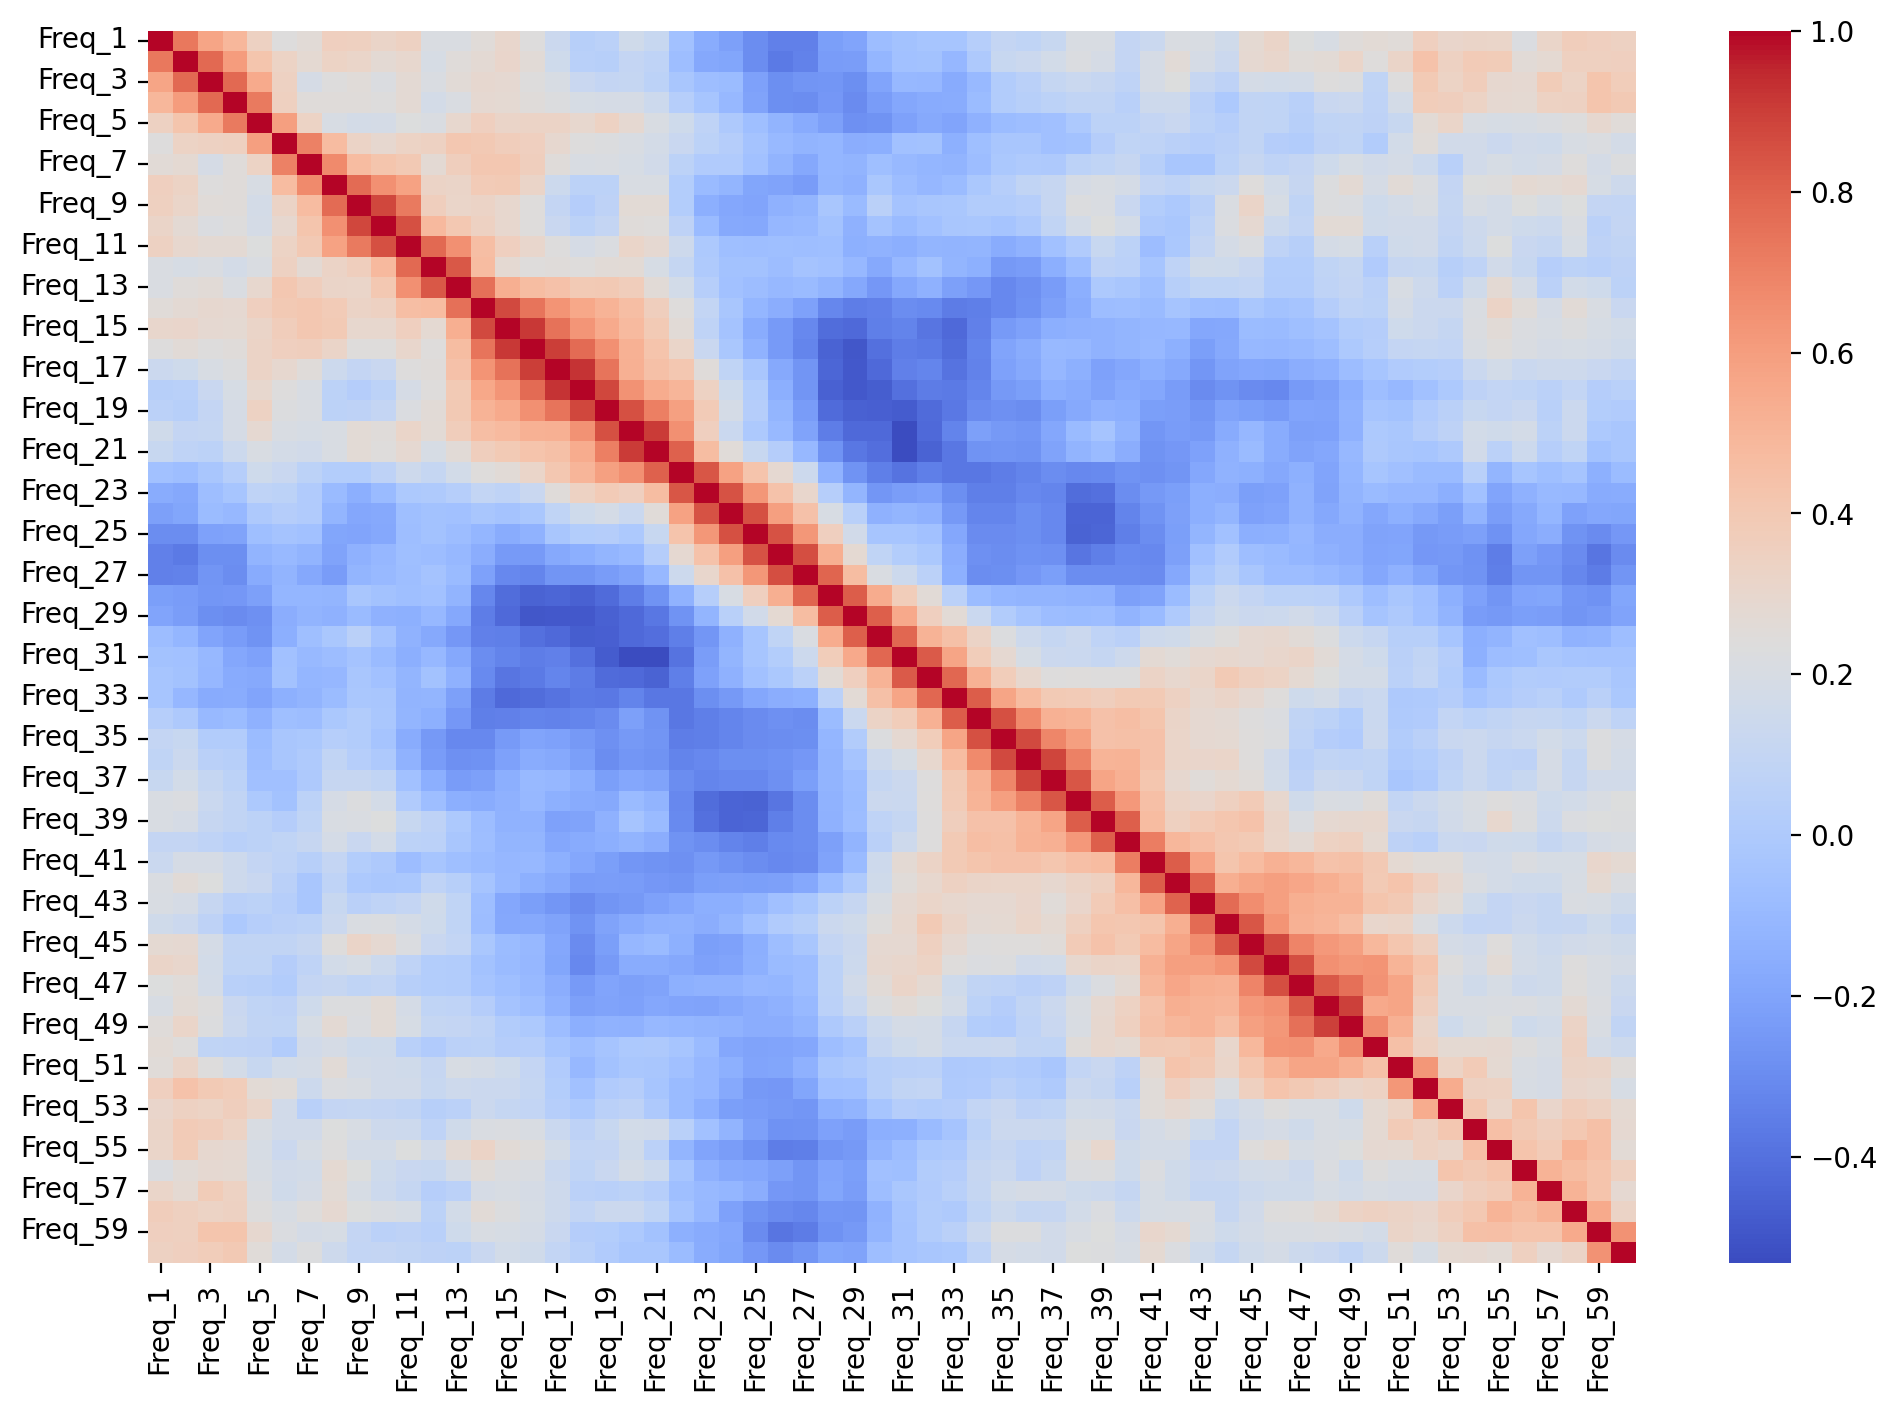

In [7]:
plt.figure(figsize=(12, 8), dpi=200)
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')
plt.show()

**Выясним, какие 5 частот лучше всего коррелируют с целевой переменной.**

*Замечание: можно пометить целевую переменную с помощью значений 0 и 1.*

*Замечание 2: мы ищем **абсолютные** значения корреляции.*

In [9]:
obj_df = df.select_dtypes(include='object')
obj_df.head()

,Label
0,R
1,R
2,R
3,R
4,R


In [11]:
df_obj_dummies = pd.get_dummies(obj_df, drop_first=True, dtype=int)
df_obj_dummies

,Label_R
0,1
1,1
2,1
3,1
4,1
...,...
203,0
204,0
205,0
206,0


In [13]:
final_df = pd.concat([df, df_obj_dummies], axis=1)
final_df

,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label,Label_R
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R,1
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R,1
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R,1
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R,1
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,M,0
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,M,0
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,M,0
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,M,0


In [25]:
abs(final_df.corr(numeric_only=True)['Label_R']).sort_values().tail(6)

Freq_45    0.339406
Freq_10    0.341142
Freq_49    0.351312
Freq_12    0.392245
Freq_11    0.432855
Label_R    1.000000
Name: Label_R, dtype: float64

## Разбиение на обучающий и тестовый наборы данных

**Здесь мы будем использовать кросс-валидацию на 90% данных, и затем оценим результаты работы нашей модели на тестовом наборе данных в 10%.**

In [27]:
X = df.drop('Label', axis=1)
y = df['Label']

In [29]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**Создадим объект PipeLine, в котором будет StandardScaler и модель KNN**

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [39]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

In [41]:
operations = [('scaler', scaler), ('knn', knn)]

In [43]:
pipe = Pipeline(operations)

**С помощью пайплайна выполним поиск по сетке для различных значений k, и выведем наилучшие параметры.**

In [57]:
k_values = list(range(1, 30))
k_values

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [49]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [59]:
param_grid = {'knn__n_neighbors': k_values}

In [61]:
full_cv_classifier = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='accuracy')

In [63]:
full_cv_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20, 21, 22, 23, 24, 25, 26, 27,
                                              28, 29]},
             scoring='accuracy')

In [65]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

**Используя словарь .cv_results_, нарисуем график средних тестовых оценок (mean_test_score) для каждого значения K.**

In [69]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.84537696, 0.78065434, 0.77524893, 0.75917496, 0.75931721,
       0.74822191, 0.75945946, 0.71664296, 0.7113798 , 0.68421053,
       0.70042674, 0.68435277, 0.68449502, 0.67908962, 0.69530583,
       0.68990043, 0.7113798 , 0.70042674, 0.72204836, 0.67908962,
       0.70071124, 0.69530583, 0.69530583, 0.68463727, 0.68477952,
       0.67923186, 0.67411095, 0.65775249, 0.6685633 ])

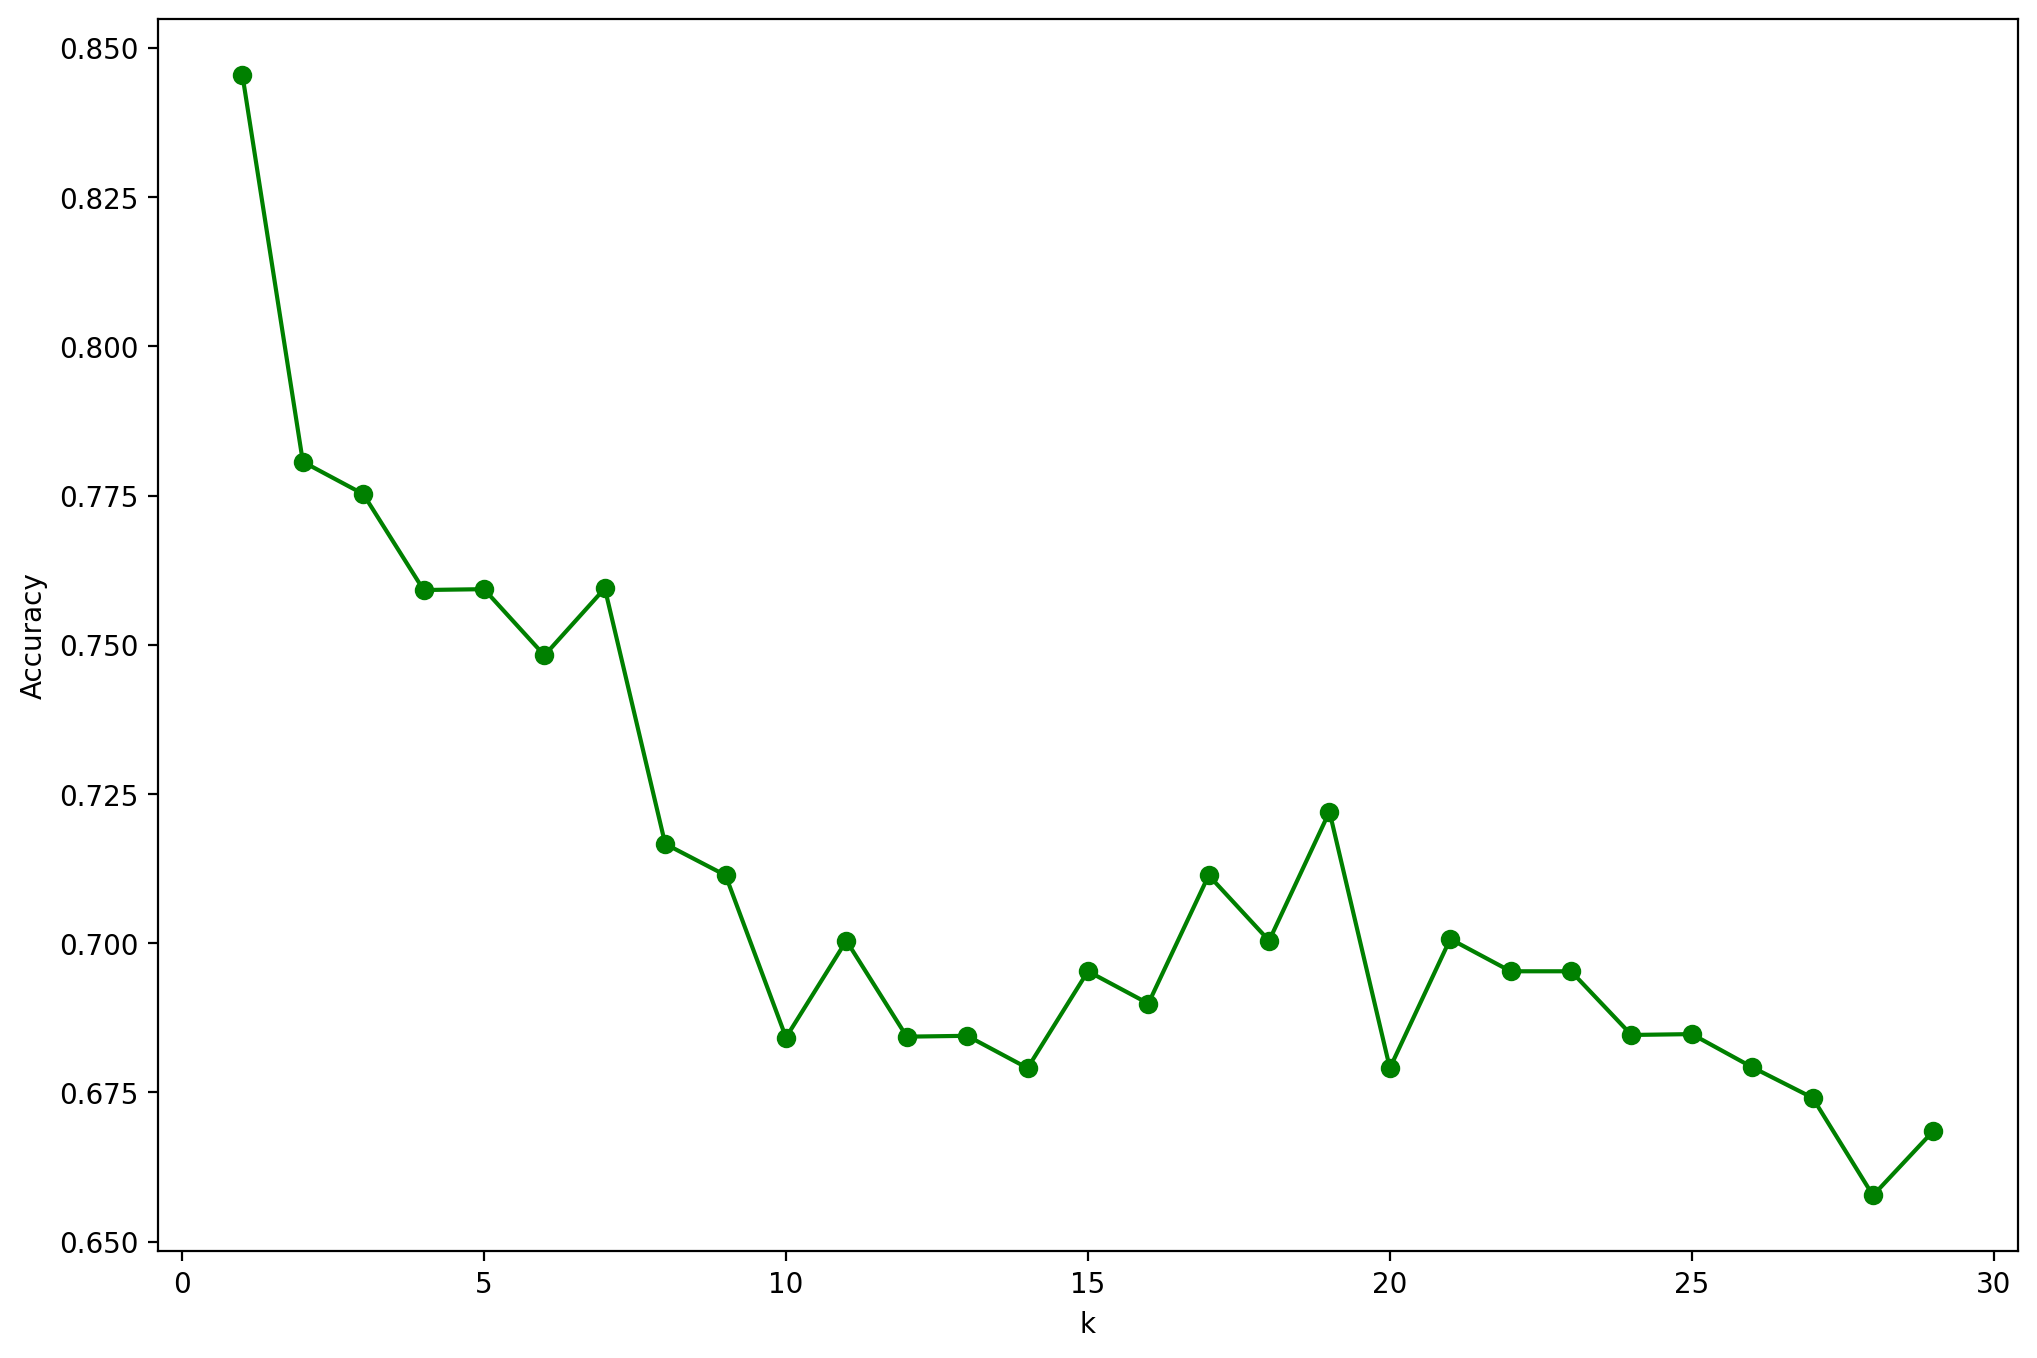

In [73]:
plt.figure(figsize=(12, 8), dpi=200)
plt.plot(range(1, 30), full_cv_classifier.cv_results_['mean_test_score'], color='green', marker='o')
plt.ylabel('Accuracy')
plt.xlabel('k')
plt.show()

Либо можно так:

pd.DataFrame(full_cv_classifier.cv_results_)['mean_test_score'].plot()

### Финальная оценка модели

**Используя объект grid classifier с предыдущего шага, создадим финальный отчёт "classification report" и матрицу "confusion matrix".**

In [75]:
from sklearn.metrics import classification_report, confusion_matrix

In [77]:
y_pred = full_cv_classifier.predict(X_test)

In [79]:
confusion_matrix(y_test, y_pred)

array([[12,  1],
       [ 1,  7]], dtype=int64)

In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           M       0.92      0.92      0.92        13
           R       0.88      0.88      0.88         8

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



---